# Deepfake detection using DINOv2

In [1]:
!pip install -q timm huggingface_hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import timm
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import io
import random
from torchvision import transforms
from PIL import Image
from huggingface_hub import hf_hub_download
from torch.utils.data import Dataset, DataLoader

# Configuration
class Config:
    HF_REPO_ID = "pujanpaudel/deepfake_face_classification"
    DATA_ROOT = '/content/dataset'
    MODEL_PATH = '/content/drive/MyDrive/dinov2_reg4_deepfake.pth'
    MODEL_NAME = "vit_small_patch14_reg4_dinov2"
    RESOLUTION = 224
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class RAMBufferedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        self.targets = []

        # Handle potential nesting from unzip
        if 'test' in os.listdir(root_dir) and os.path.isdir(os.path.join(root_dir, 'test')):
            root_dir = os.path.join(root_dir, 'test')

        print(f"Indexing {root_dir}...")
        classes = {'real': 0, 'fake': 1}

        for class_name, label in classes.items():
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path): continue

            files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            for img_name in files:
                with open(os.path.join(class_path, img_name), 'rb') as f:
                    self.samples.append(f.read())
                self.targets.append(label)
        print(f"Loaded {len(self.samples)} images.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_bytes = self.samples[idx]
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.targets[idx]

def setup_test_data():
    print(f"Downloading test data...")
    test_zip_path = hf_hub_download(
        repo_id=Config.HF_REPO_ID,
        filename="test.zip",
        repo_type="dataset",
        local_dir='/content/downloads'
    )
    extract_path = os.path.join(Config.DATA_ROOT, 'test')
    if not os.path.exists(extract_path):
        with zipfile.ZipFile(test_zip_path, 'r') as z:
            z.extractall(extract_path)
    return extract_path

# Run setup
test_dir = setup_test_data()
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
val_tf = transforms.Compose([
    transforms.Resize((Config.RESOLUTION, Config.RESOLUTION)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_ds = RAMBufferedDataset(test_dir, transform=val_tf)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


test.zip:   0%|          | 0.00/857M [00:00<?, ?B/s]

Indexing /content/dataset/test/test...
Loaded 3212 images.


In [5]:
def load_model():
    print(f"Loading model : {Config.MODEL_NAME}...")
    model = timm.create_model(
        Config.MODEL_NAME,
        pretrained=False,
        num_classes=2,
        img_size=Config.RESOLUTION
    ).to(Config.DEVICE)

    print(f"Loading weights from {Config.MODEL_PATH}...")
    state_dict = torch.load(Config.MODEL_PATH, map_location=Config.DEVICE)
    model.load_state_dict(state_dict)
    model.eval()
    print("Model loaded successfully!")
    return model

model = load_model()

Loading model : vit_small_patch14_reg4_dinov2...
Loading weights from /content/drive/MyDrive/dinov2_reg4_deepfake.pth...
Model loaded successfully!


In [6]:
import torch.nn.functional as F

for block in model.blocks:
    if hasattr(block.attn, 'fused_attn'): block.attn.fused_attn = False
    if hasattr(block.attn, 'use_fused_attn'): block.attn.use_fused_attn = False

attention_weights = []
def get_attn_hook(module, input, output):
    attention_weights.append(input[0])

for block in model.blocks:
    if hasattr(block.attn.attn_drop, "_forward_hooks"):
        block.attn.attn_drop._forward_hooks.clear()

hook = model.blocks[-1].attn.attn_drop.register_forward_hook(get_attn_hook)

Picking random fake images...
Analyzing Indices: [1920, 2336, 2793, 2635]


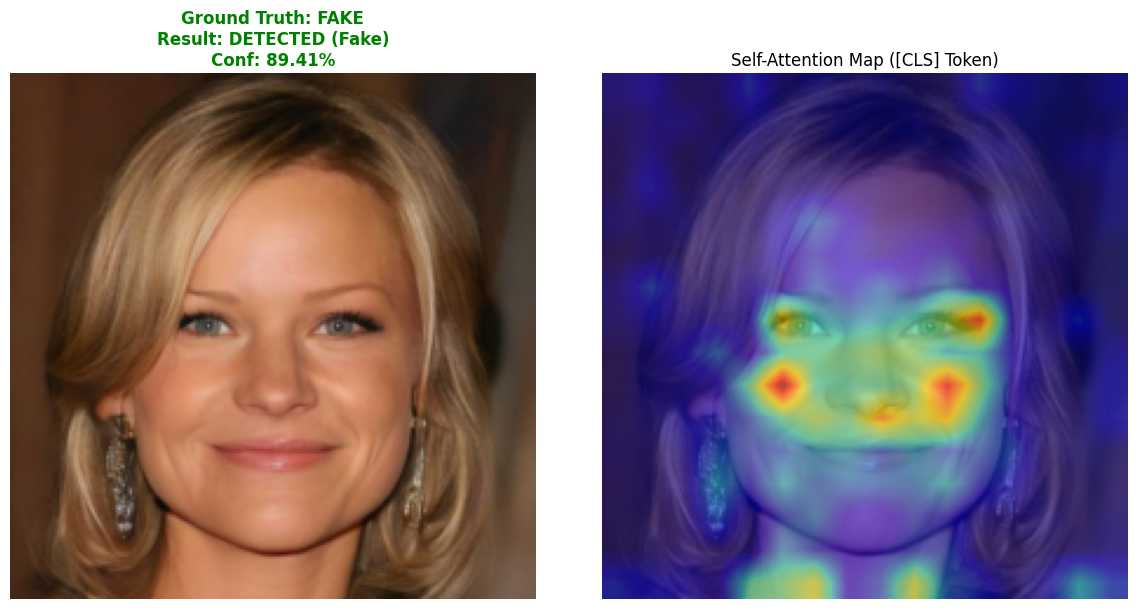

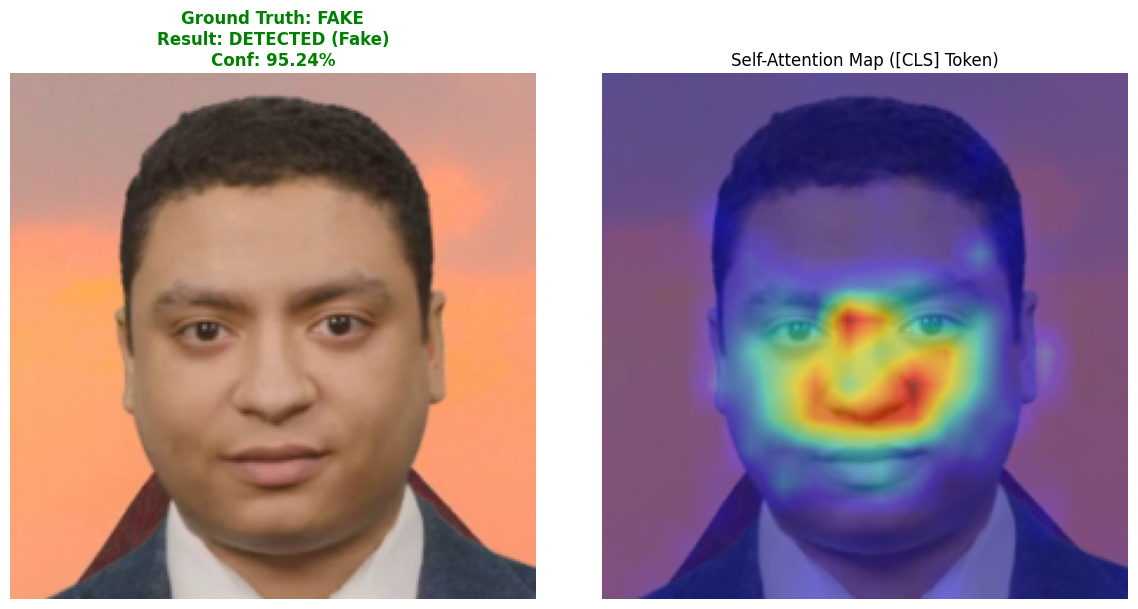

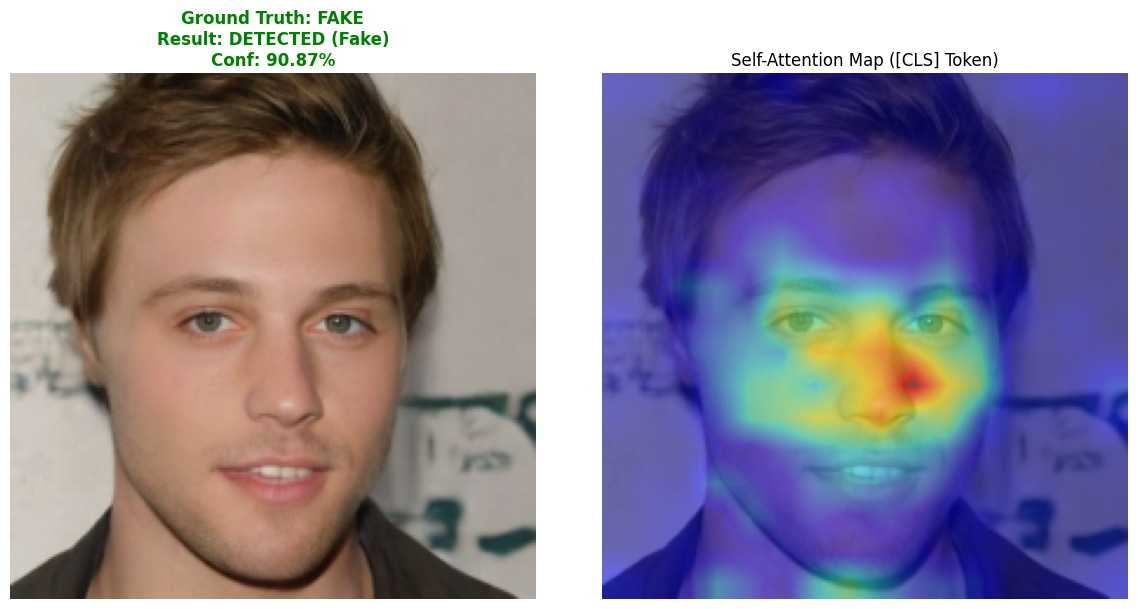

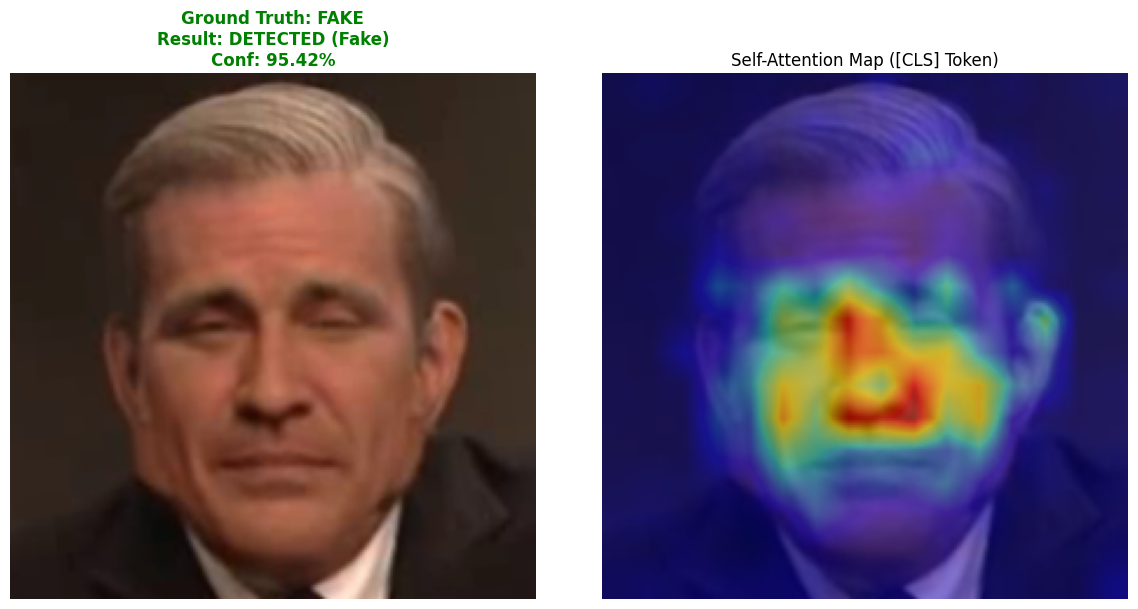

In [9]:
def visualize_random_samples(model, dataset, device, num_images=3):
    model.eval()
    print("Picking random fake images...")

    fake_indices = [i for i, x in enumerate(dataset.targets) if x == 1]

    if len(fake_indices) < num_images:
        print("Not enough fake images found!")
        return


    selected_indices = random.sample(fake_indices, num_images)
    print(f"Analyzing Indices: {selected_indices}")

    for idx in selected_indices:
        image, label = dataset[idx]


        images = image.unsqueeze(0).to(device)

        attention_weights.clear()

        with torch.no_grad():
            outputs = model(images)
            pred_label = outputs.argmax(1).item()
            prob = torch.softmax(outputs, dim=1)[0][pred_label].item()

        # Get Matrix from hook
        if not attention_weights:
            print("Error: No attention weights captured. Check hooks.")
            continue

        attn_mat = attention_weights[0].cpu() # [1, Heads, Tokens, Tokens]

        # --- PROCESS ATTENTION ---
        patch_size = 14
        patch_start_index = 5

        num_tokens = attn_mat.shape[-1]
        num_patches = num_tokens - patch_start_index
        grid_size = int(num_patches**0.5)

        cls_attn = attn_mat[0, :, 0, patch_start_index:]
        cls_attn = cls_attn.mean(dim=0) # Average across attention heads

        cls_attn = cls_attn.reshape(grid_size, grid_size)

        cls_attn_resized = cv2.resize(cls_attn.numpy(), (Config.RESOLUTION, Config.RESOLUTION))
        cls_attn_tensor = torch.tensor(cls_attn_resized)

        # --- PLOT ---
        img_original = images[0].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_original = (img_original * std + mean).clip(0, 1)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        status_color = 'green' if pred_label == 1 else 'red'
        status_text = "DETECTED (Fake)" if pred_label == 1 else "MISSED (Pred Real)"

        ax[0].imshow(img_original)
        ax[0].set_title(f"Ground Truth: FAKE\nResult: {status_text}\nConf: {prob:.2%}", color=status_color, weight='bold')
        ax[0].axis('off')

        ax[1].imshow(img_original)
        ax[1].imshow(cls_attn_tensor, cmap='jet', alpha=0.5)
        ax[1].set_title("Self-Attention Map ([CLS] Token)")
        ax[1].axis('off')

        plt.tight_layout()
        plt.show()

# Run the visualizer
visualize_random_samples(model, test_ds, Config.DEVICE, num_images=4)

### Ablation comparision (Full Fine Tune vs Head Only)

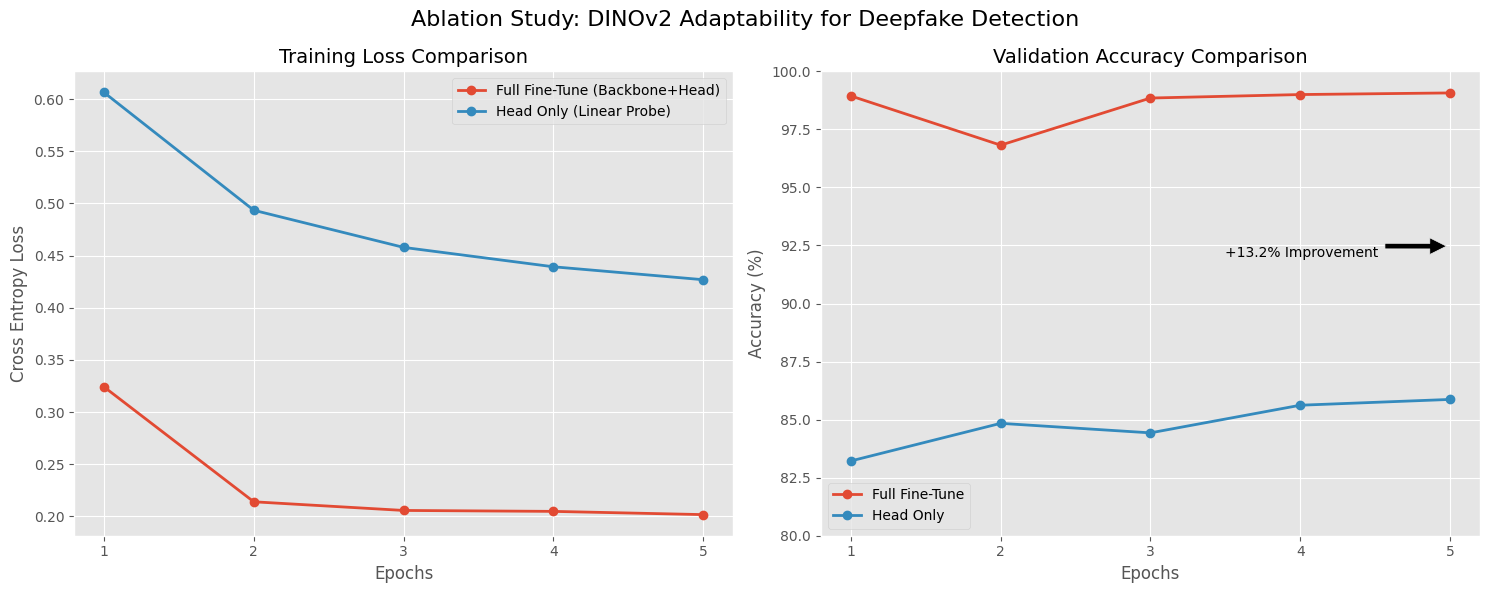

In [12]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 6)

# Model A: Full Fine-Tune
fft_loss = [0.3241, 0.2139, 0.2056, 0.2047, 0.2016]
fft_train_acc = [91.93, 99.40, 99.69, 99.71, 99.86]
fft_val_acc = [98.94, 96.82, 98.85, 99.00, 99.07]

# Model B: Head Only (Ablation)
ho_loss = [0.6065, 0.4935, 0.4579, 0.4393, 0.4269]
ho_train_acc = [68.97, 81.25, 83.76, 84.73, 85.82]
ho_val_acc = [83.22, 84.84, 84.43, 85.62, 85.87]

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Plot 1: Training Loss ---
ax1.plot(epochs, fft_loss, 'o-', label='Full Fine-Tune (Backbone+Head)', linewidth=2)
ax1.plot(epochs, ho_loss, 'o-', label='Head Only (Linear Probe)', linewidth=2)
ax1.set_title('Training Loss Comparison', fontsize=14)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross Entropy Loss')
ax1.set_xticks(epochs)
ax1.legend()
ax1.grid(True)

# --- Plot 2: Validation Accuracy ---
ax2.plot(epochs, fft_val_acc, 'o-', label='Full Fine-Tune', linewidth=2)
ax2.plot(epochs, ho_val_acc, 'o-', label='Head Only', linewidth=2)
ax2.set_title('Validation Accuracy Comparison', fontsize=14)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.set_xticks(epochs)
ax2.set_ylim(80, 100) # Zoom in to show the gap clearly
ax2.legend()
ax2.grid(True)

# Annotate the final gap
gap = fft_val_acc[-1] - ho_val_acc[-1]
ax2.annotate(f'+{gap:.1f}% Improvement',
             xy=(5, (fft_val_acc[-1] + ho_val_acc[-1])/2),
             xytext=(3.5, 92),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.suptitle(f"Ablation Study: DINOv2 Adaptability for Deepfake Detection", fontsize=16)
plt.tight_layout()
plt.show()